##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
# import warnings
# warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
# import LSTM_Train as LSTM
import importlib
import LSTM
import Dense as Dense
importlib.reload(LSTM)
importlib.reload(Dense)
importlib.reload(RSTF)

%matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# pool.close()

In [2]:
FillVar = 'fch4'
FullModel = ['H','wind_speed','air_pressure','PPFD_Avg','AirTC_Avg',
             'VPD','Temp','VWC','Sedge','Shrub','Grass','Sparse','Out_of_Basin']
FullModel = ['PPFD_Avg','AirTC_Avg','Sedge','VPD']
Runs,params = Dense.Params('Test',FillVar,MP=False)

In [3]:
def TTV_Split(i,Memory,X,y,params,X_fill):
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=i)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=i)
    return(Dense.Train_Steps(params['epochs'],params['N'],X_train,X_test,X_val,y_train,y_test,
                            y_val,i,X_fill = X_fill,Memory=Memory))

Time = time.time()
Path = 'Data_Footprints_2018-06-12.csv'

# plt.figure(figsize=(10,10))
def RunReps(Model,params,pool = None,plot=False,FullReturn=False):
    RST = RSTF.ReadStandardTimeFill(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    if params['T'] >0:
        RST.TimeShape(params['T'])
    y = RST.y*1.0
    X = RST.X*1.0
    X_fill = RST.X_fill*1.0
    MSE = []
#     STD = []
    Y_fill = []
    Yval = []
    y_val= []
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params,X_fill=X_fill),
                                             range(params['K']))):

            MSE.append(results[0])
            Y_fill.append(results[1])
            Yval.append(results[2])
            y_val.append(results[3])
    else:
        for i in range(params['K']):
            results = TTV_Split(i,Memory,X,y,params,X_fill)
            MSE.append(results[0])
            Y_fill.append(results[1])
            Yval.append(results[2])
            y_val.append(results[3])
    MSE = np.asanyarray(MSE)
    Y_fill = np.asanyarray(Y_fill)
    Y_fill = Y_fill.mean(axis=0)
    
    Yval = np.asanyarray(Yval)
    Yval = Yval.mean(axis=0)
    y_val = np.asanyarray(y_val)
    y_val = y_val.mean(axis=0)
    
    FillVarName = FillVar.replace('f','F')
    RST.Fill(Y_fill,FillVarName)
        
    if FullReturn == False:
        return(MSE,RST.Master['TempFill'])
    else:
        return(MSE,RST.Master)

if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=75)
else:pool=None
    
for i in Runs.index:
    try:
        params['T']=Runs['T'].iloc[i]
    except:
        params['T'] = 0
    params['N']=Runs['N'].iloc[i]
    Results = RunReps(FullModel,params,pool,plot=True)
    MSE = Results[0]
    Runs['MSE'][i]=MSE.mean()
    Runs['STD'][i]=MSE.std()
    Runs['SE'][i]=MSE.std()/(params['K']**.5)
    print('Finisehed Run ',str(i),' MSE: ',MSE.mean())

Runs['CI'] = Runs['STD']/params['K']**.5*stats.t.ppf(1-0.05, params['K']-2)

def Curve(x,a,b,c):
    return (a/(b+x)**c)

popt, pcov = curve_fit(Curve, Runs['N'].values, Runs['MSE'].values)

print(time.time()-Time)

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Finisehed Run  0  MSE:  1.17657429061
Finisehed Run  1  MSE:  1.02744716191
Finisehed Run  2  MSE:  0.918148672155
Finisehed Run  3  MSE:  0.930861447601
Finisehed Run  4  MSE:  0.912242153188
Finisehed Run  5  MSE:  0.896814552201
Finisehed Run  6  MSE:  0.873953908543
Finisehed Run  7  MSE:  0.88338601114
Finisehed Run  8  MSE:  0.891696446389
108.37153840065002


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in power


# The "Optimum" Sized Model

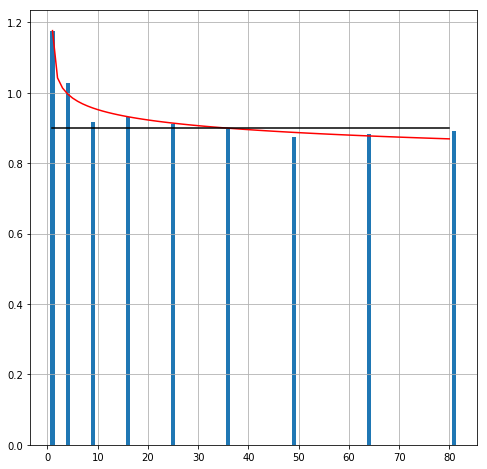

35


,N,MSE,STD,CI,SE
0,1,1.176574,0.176094,0.185331,0.078752
1,4,1.027447,0.141265,0.148675,0.063176
2,9,0.918149,0.103906,0.109357,0.046468
3,16,0.930861,0.077697,0.081772,0.034747
4,25,0.912242,0.056141,0.059086,0.025107
5,36,0.896815,0.062281,0.065548,0.027853
6,49,0.873954,0.060030,0.063179,0.026846
7,64,0.883386,0.080635,0.084865,0.036061
8,81,0.891696,0.076509,0.080523,0.034216


In [4]:
fig,ax = plt.subplots(figsize=(8,8))
ax.bar(Runs['N'],Runs['MSE'])

N = np.arange(Runs['N'].min(),Runs['N'].max())
Fit = Curve(N,*popt)
ax.plot(N,Fit,color='r')
Min = Runs.loc[Runs['MSE']==Runs['MSE'].min()]
Max = (Min['MSE']+Min['SE']).values[0]
ax.plot(N,N*0+Max,color = 'black')
params['N']=N[Fit<Max].min()
plt.grid()
plt.show()
print(params['N'])
Runs

# Feature Identification

In [5]:
def Tukeys(Names,Values,Best,Past_Best = None, p = .2):
    Best = list(Best)
    d = {'Model':Names,'MSE':Values}
    Data = pd.DataFrame(data=d)
    posthoc = pairwise_tukeyhsd(
        Data['MSE'], Data['Model'],
        alpha=p)
    c = 0
    for i,val in enumerate(posthoc.groupsunique):
        for j,vayl in enumerate(posthoc.groupsunique[i+1:]): 
            if posthoc.reject[c] == False:
                if vayl == Best[0]:
                    Best.append(val)
                if val == Best[0]:
                    Best.append(vayl)
            c+=1
    return(Best)

In [6]:
def Combos(Model,L,factor=None):
    Models=list()
    for c in combinations(Model,L):
        c = list(c)
        if factor is None:
            Models.append(c)
        else:
            for f in factor:
                f = f.split('+')
                if set(f).issubset(set(c)) and c not in Models:
                    Models.append(c)
    return(Models)

Scores = Runs[['MSE','CI','STD','SE']].reset_index(drop=True)
Scores = (Scores.iloc[0:1])*0
Scores['Level'] = len(FullModel)
Scores['Key'] = str(Scores['Level'][0])+'_0'
Scores['Model'] = '+'.join(FullModel)
Scores['Best'] = 'N'

Results = RunReps(FullModel,params,pool)

MSE = Results[0]
mean,std = MSE.mean(),MSE.std()
CI = std/params['K']**.5*stats.t.ppf(1-0.05, params['K']-1)
Scores['MSE']=mean
Scores['STD']=std
Scores['SE']=std/params['K']**.5
Scores['CI']=CI

ModelRuns = Results[1]
ModelRuns = ModelRuns.to_frame()
ModelRuns['Model: '+'+'.join(FullModel)]=ModelRuns['TempFill']
ModelRuns=ModelRuns.drop('TempFill',axis=1)

for i in range(1,len(FullModel)):
    print('Level: ',i)
    if i == 1:
        Models = Combos(FullModel,i)
    else:
        Models = Combos(FullModel,i,factor = Best)
    Values = []
    Names = []
    for i,model in enumerate(Models):
        level = len(model)
        key = str(level)+'_'+str(i)
        Name = '+'.join(model)
        NewRow = Scores.iloc[-1].copy()
        NewRow['Model'] = 'Model: '+Name
        Results = RunReps(model,params,pool)
        MSE = Results[0]
        for mse in MSE:
            Names.append(Name)
            Values.append(mse)
        mean,std = MSE.mean(),MSE.std()
        CI = std/params['K']**.5*stats.t.ppf(1-0.05, params['K']-1)
        d = {'Model':'+'.join(model),'MSE':mean,'STD':std,'Level':level,
             'CI':CI,'SE':std/params['K']**.5,'Key':key,'Best':'N'}
        score = pd.DataFrame(index=[0],data=d)
        print(model,mean)
        Scores = Scores.append(score,ignore_index=True)
        ModelRuns['Model: '+'+'.join(model)] = Results[1]    
    
    Min = Scores.loc[Scores['Level']==level]
    Min = Min.loc[Min['MSE'] == Min['MSE'].min(),'Model'].values
    Best = Tukeys(Names,Values,Min)
    Scores.loc[Scores['Model'].isin(Best),'Best']='Y'
    Best = Min

Level:  1
['PPFD_Avg'] 1.1335375781
['AirTC_Avg'] 1.08214403562
['Sedge'] 1.03780550869
['VPD'] 1.12271008754
Level:  2
['PPFD_Avg', 'Sedge'] 0.935998223297
['AirTC_Avg', 'Sedge'] 0.976981823015
['Sedge', 'VPD'] 1.05055273993
Level:  3
['PPFD_Avg', 'AirTC_Avg', 'Sedge'] 0.929910474963
['PPFD_Avg', 'Sedge', 'VPD'] 0.959488864805


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Finisehed Run  0  MSE:  1.12408846418
Finisehed Run  1  MSE:  1.01868818277
Finisehed Run  2  MSE:  0.975775705668
Finisehed Run  3  MSE:  0.92432190503
Finisehed Run  4  MSE:  0.913559130466
Finisehed Run  5  MSE:  0.920989540744
Finisehed Run  6  MSE:  0.933780498958
Finisehed Run  7  MSE:  0.932509182138
Finisehed Run  8  MSE:  0.927967645833


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


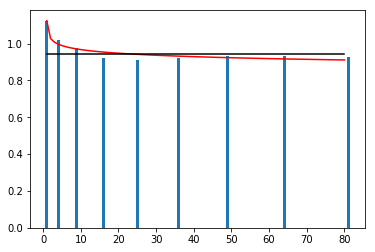

    N       MSE       STD        CI        SE
0   1  1.124088  0.122633  0.129066  0.054843
1   4  1.018688  0.148809  0.156614  0.066549
2   9  0.975776  0.083896  0.088297  0.037519
3  16  0.924322  0.074074  0.077960  0.033127
4  25  0.913559  0.070088  0.073765  0.031344
5  36  0.920990  0.081043  0.085294  0.036243
6  49  0.933780  0.092588  0.097445  0.041407
7  64  0.932509  0.079668  0.083847  0.035629
8  81  0.927968  0.077151  0.081198  0.034503
['PPFD_Avg+AirTC_Avg+Sedge']
['PPFD_Avg', 'AirTC_Avg', 'Sedge'] 0.950602839664
23


In [7]:

def Curve(x,a,b,c):
    return (a/(b+x)**c)

N = Runs['N']
NRuns = Runs*0
NRuns['N']=N

model = Best[0].split('+')

for i in NRuns.index:
    try:
        params['T']=NRuns['T'].iloc[i]
    except:
        params['T'] = 0
    params['N']=NRuns['N'].iloc[i]
    Results = RunReps(model,params,pool,plot=False)
    MSE = Results[0]
    NRuns['MSE'][i]=MSE.mean()
    NRuns['STD'][i]=MSE.std()
    NRuns['SE'][i]=MSE.std()/(params['K']**.5)
    print('Finisehed Run ',str(i),' MSE: ',MSE.mean())

NRuns['CI'] = NRuns['STD']/params['K']**.5*stats.t.ppf(1-0.05, params['K']-2)

popt, pcov = curve_fit(Curve, NRuns['N'].values, NRuns['MSE'].values)

fig,ax = plt.subplots()
ax.bar(NRuns['N'],NRuns['MSE'])
N = np.arange(Runs['N'].min(),Runs['N'].max())
Fit = Curve(N,*popt)
ax.plot(N,Fit,color='r')
Min = NRuns.loc[NRuns['MSE']==NRuns['MSE'].min()]
Max = (Min['MSE']+Min['SE']).values[0]
ax.plot(N,N*0+Max,color = 'black')
params['N']=N[Fit<Max].min()
plt.show()

print(NRuns)


level = len(Best)
print(Best)
key = '0_'+str(params['N'])
Name = '+'.join(Best)
NewRow = Scores.iloc[-1].copy()
NewRow['Model'] = 'BestModel: '+Name
Results = RunReps(model,params,pool)
MSE = Results[0]
for mse in MSE:
    Names.append(Name)
    Values.append(mse)
mean,std = MSE.mean(),MSE.std()
CI = std/params['K']**.5*stats.t.ppf(1-0.05, params['K']-1)
d = {'Model':'+'.join(model),'MSE':mean,'STD':std,'Level':0,
     'CI':CI,'SE':std/params['K']**.5,'Key':key,'Best':'N'}
score = pd.DataFrame(index=[0],data=d)
print(model,mean)
Scores = Scores.append(score,ignore_index=True)
ModelRuns['BestModel: '+'+'.join(model)] = Results[1] 


print(params['N'])
# print(time.time()-Time)



In [8]:

Scores.to_csv('GapFillingSummary'+FillVar+'.csv')
ModelRuns.to_csv('GapFilled'+FillVar+'.csv')

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

print(time.time()-Time)

559.3080406188965


In [9]:
Scores

,Best,CI,Key,Level,MSE,Model,SE,STD
0,N,0.058422,4_0,4,0.901593,PPFD_Avg+AirTC_Avg+Sedge+VPD,0.027404,0.061278
1,Y,0.136829,1_0,1,1.133538,PPFD_Avg,0.064183,0.143519
2,Y,0.106144,1_1,1,1.082144,AirTC_Avg,0.049790,0.111333
3,Y,0.097296,1_2,1,1.037806,Sedge,0.045639,0.102053
4,Y,0.131018,1_3,1,1.122710,VPD,0.061458,0.137424
5,Y,0.058575,2_0,2,0.935998,PPFD_Avg+Sedge,0.027476,0.061439
6,Y,0.056312,2_1,2,0.976982,AirTC_Avg+Sedge,0.026415,0.059065
7,N,0.104026,2_2,2,1.050553,Sedge+VPD,0.048796,0.109111
8,Y,0.072260,3_0,3,0.929910,PPFD_Avg+AirTC_Avg+Sedge,0.033896,0.075793
9,Y,0.069339,3_1,3,0.959489,PPFD_Avg+Sedge+VPD,0.032525,0.072729
